In [1]:
import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from dataandcoords import set_data_and_coords
from gpapproximation import make_gp_basis
from posteriorplots import predictive_plot, retrodictive_plot
from zerosumnormal import ZeroSumNormal

if pm.math.erf.__module__.split(".")[0] == "theano":
    import theano.tensor as aet
else:
    import aesara.tensor as aet

In [2]:
arviz.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

In [3]:
COORDS = {
    "parties": ["farleft", "left", "green", "center", "right", "farright"],
    "parties_complete": [
        "farleft",
        "left",
        "green",
        "center",
        "right",
        "farright",
        "other",
    ],
}

## Data

In [4]:
polls = pd.read_csv(
    "../../data/polls_1st_round/tour1_complet_unitedfl.csv",
    index_col=0,
    parse_dates=["dateelection", "date"],
)
polls = polls[(polls.date >= "2002-01") & (polls.type == "president")].drop(
    [
        "type",
        "abstention",
        "undecided",
    ],
    axis=1,
)
polls.loc[polls["dateelection"] == "2017-04-23", "nbgreen"] = 0
polls = polls.sort_values(
    ["dateelection", "date", "sondage", "samplesize"]
).reset_index(drop=True)

In [5]:
def dates_to_idx(timelist, reference_date):
    """Convert datetimes to numbers in reference to reference_date"""

    t = (reference_date - timelist) / np.timedelta64(1, "D")

    return np.asarray(t)

In [6]:
# start all elections on Jan 1st
dfs = []
for date in polls.dateelection.unique():
    date = pd.to_datetime(date)
    df = polls[(polls.dateelection == date) & (polls.date >= f"{date.year}-01")]
    df["countdown"] = dates_to_idx(df["date"], date).astype(int)
    dfs.append(df)

<ipython-input-6-a58aca392740>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["countdown"] = dates_to_idx(df["date"], date).astype(int)


In [7]:
# compute "other" category
polls = (
    pd.concat(dfs)
    .set_index(["dateelection", "date", "countdown", "sondage", "samplesize"])
    .rename(columns={col: col.split("nb")[1] for col in polls if col.startswith("nb")})[
        COORDS["parties"]
    ]
)
polls["other"] = 100 - polls.sum(1)
polls = polls.reset_index()

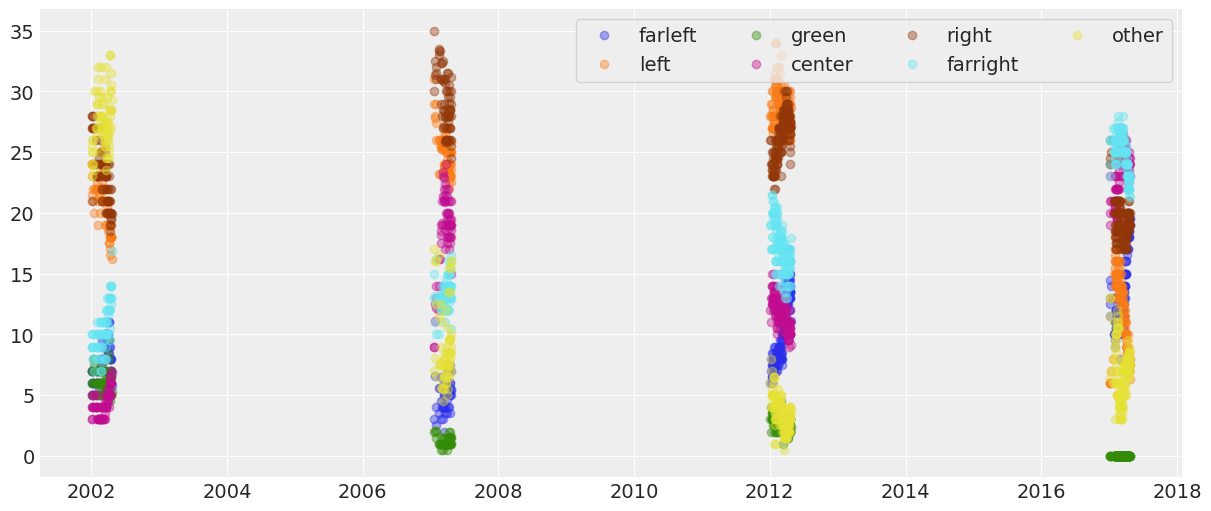

In [9]:
fig, ax = plt.subplots(figsize=(12, 5))
for p in COORDS["parties_complete"]:
    ax.plot(polls["date"], polls[p], "o", label=p, alpha=0.4)
ax.legend(ncol=4, frameon=True, loc="upper right");

In [10]:
# isolate results
results = polls[polls.sondage == "result"]
polls = polls[polls.sondage != "result"].set_index(["date", "sondage"])

In [11]:
# cast as multinomial obs
polls[COORDS["parties_complete"]] = (
    (polls[COORDS["parties_complete"]] / 100)
    .mul(polls["samplesize"], axis=0)
    .round()
    .fillna(0)
    .astype(int)
)
polls["samplesize"] = polls[COORDS["parties_complete"]].sum(1)
polls = polls.reset_index()

# add column to track week
polls["week"] = polls.date.dt.isocalendar().week.astype("int64") - 1
polls

,date,sondage,dateelection,countdown,samplesize,farleft,left,green,center,right,farright,other,week
0,2002-01-02,BVA,2002-04-21,109,919,64,221,64,46,193,92,239,0
1,2002-01-03,CSA,2002-04-21,108,997,50,214,60,40,279,100,254,0
2,2002-01-04,Ipsos,2002-04-21,107,5297,318,1218,265,212,1483,477,1324,0
3,2002-01-05,BVA,2002-04-21,106,500,35,120,35,15,135,45,115,0
4,2002-01-05,Kantar,2002-04-21,106,763,53,183,46,23,206,69,183,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,2017-04-20,Elabe,2017-04-23,3,1196,233,84,0,287,239,257,96,15
432,2017-04-20,Ifop,2017-04-23,3,1901,352,133,0,466,370,428,152,15
433,2017-04-20,Ipsos,2017-04-23,3,1400,266,105,0,336,266,308,119,15
434,2017-04-21,BVA,2017-04-23,2,1134,221,91,0,261,215,261,85,15


In [ ]:
# add structure for other elections
# add popularity and econ variables as predictors

### Plain Multinomial

In [12]:
pollster_id, COORDS["pollsters"] = polls["sondage"].factorize(sort=True)
countdown_id, COORDS["countdown"] = polls.countdown.values, np.arange(
    polls.countdown.max() + 1
)
election_id, COORDS["elections"] = polls["dateelection"].factorize()
COORDS["observations"] = polls.set_index(["date", "sondage", "samplesize"]).index

In [42]:
with pm.Model(coords=COORDS) as plain_mult:

    bias = ZeroSumNormal("bias", sigma=0.15, dims="pollsters")
    mu = pm.GaussianRandomWalk(
        "mu", sigma=1.0, dims=("countdown", "parties")
    )  # MvGaussianRW / GP with lag for momentum

    popularity = pm.Deterministic(
        "popularity",
        aet.nnet.softmax(
            aet.concatenate(
                [
                    mu[countdown_id[::-1]] + bias[pollster_id][:, None],
                    aet.zeros((len(twelve), 1)),
                ],
                axis=-1,
            )
        ),
        dims=("observations", "parties_complete"),
    )

    N_approve = pm.Multinomial(
        "N_approve",
        p=popularity,
        n=twelve["samplesize"].values,
        observed=twelve[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, bias]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.


0, dim: observations, 152 =? 152
1, dim: parties_complete, 1 =? 7


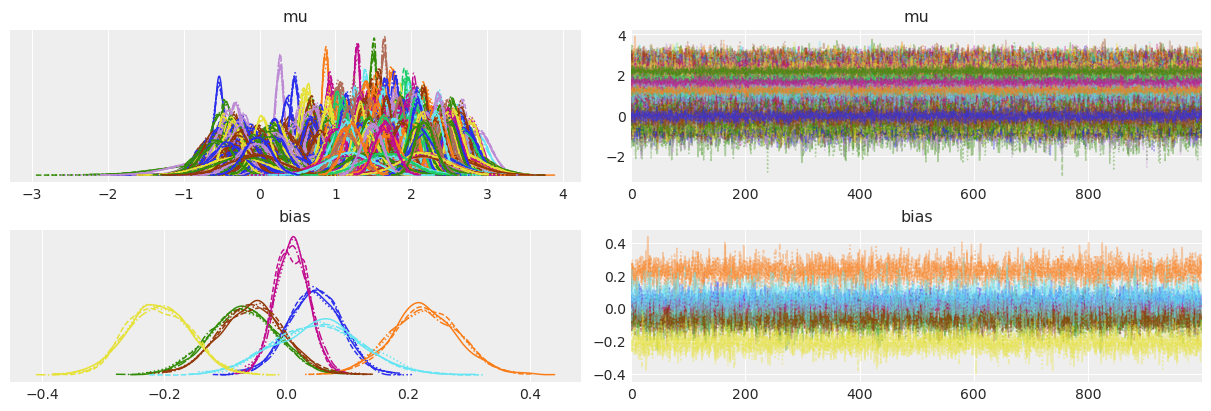

In [43]:
arviz.plot_trace(idata, var_names=["~popularity"]);

In [33]:
GP_CONFIG = {
    "lengthscale": [7, 17, 28],
    "kernel": "gaussian",
    "zerosum": True,
    "variance_limit": 0.95,
    "variance_weight": [0.5, 0.2, 0.3],
}

In [34]:
with pm.Model(coords=COORDS) as plain_mult:
    intercept = ZeroSumNormal(
        "intercept", sigma=0.1, dims=("elections", "parties_complete"), zerosum_axes=-1
    )
    house_effects = ZeroSumNormal(
        "house_effects",
        sigma=0.1,
        dims=("pollsters", "parties_complete", "elections"),
        zerosum_axes=(0, 1),
    )

    lsd_intercept = pm.Normal("lsd_intercept", dims="elections")
    shrinkage = pm.HalfNormal("shrinkage", 0.1, dims="elections")
    raw_lsd = ZeroSumNormal(
        "raw_lsd_party", dims=("parties_complete", "elections"), zerosum_axes=0
    )
    sd = pm.Deterministic(
        "time_weight",
        aet.exp(lsd_intercept[None, :] + shrinkage[None, :] * raw_lsd),
        dims=("parties_complete", "elections"),
    )
    # shrinkage = pm.HalfNormal("shrinkage", 0.5)
    # sd = pm.HalfNormal("time_weight", shrinkage, dims="parties_complete")

    gp_basis_funcs, gp_basis_dim = make_gp_basis(
        time=COORDS["countdown"], gp_config=GP_CONFIG, key="parties"
    )
    raw_coefs = ZeroSumNormal(
        f"raw_time_coefs",
        sigma=sd[None, ...],
        dims=(gp_basis_dim, "parties_complete", "elections"),
        zerosum_axes=-1,
    )
    gps = pm.Deterministic(
        "time_effect",
        aet.tensordot(gp_basis_funcs, raw_coefs, axes=(1, 0)),
        dims=("countdown", "parties_complete", "elections"),
    )

    # data
    election_idx = pm.Data("election_idx", election_id, dims="observations")
    pollster_idx = pm.Data("pollster_idx", pollster_id, dims="observations")
    countdown_idx = pm.Data("observed_days_idx", countdown_id, dims="observations")
    observed_N = pm.Data("observed_N", polls["samplesize"].values, dims="observations")
    observed_polls = pm.Data(
        "observed_polls",
        polls[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    # regression
    popularity = pm.Deterministic(
        "popularity",
        aet.nnet.softmax(
            intercept[election_idx]
            + house_effects[pollster_idx, :, election_idx]
            + gps[countdown_idx[::-1], :, election_idx]
        ),
        dims=("observations", "parties_complete"),
    )

    # likelihood
    N_approve = pm.Multinomial(
        "N_approve",
        p=popularity,
        n=observed_N,
        observed=observed_polls,
        dims=("observations", "parties_complete"),
    )
    # https://mc-stan.org/docs/2_27/stan-users-guide/bayesian-measurement-error-model.html

    # sampling
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [raw_time_coefs, raw_lsd_party, shrinkage, lsd_intercept, house_effects, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 401 seconds.


0, dim: observations, 436 =? 436
1, dim: parties_complete, 1 =? 7


In [35]:
with pm.Model(coords=COORDS) as plain_mult:
    intercept = ZeroSumNormal(
        "intercept", sigma=0.1, dims=("elections", "parties_complete"), zerosum_axes=-1
    )
    house_effects = ZeroSumNormal(
        "house_effects",
        sigma=0.1,
        dims=("pollsters", "parties_complete", "elections"),
        zerosum_axes=(0, 1),
    )

    lsd_intercept = pm.Normal("lsd_intercept", dims="elections")
    shrinkage = pm.HalfNormal("shrinkage", 1, dims="elections")
    raw_lsd = ZeroSumNormal(
        "raw_lsd_party", dims=("parties_complete", "elections"), zerosum_axes=0
    )
    sd = pm.Deterministic(
        "time_weight",
        aet.exp(lsd_intercept[None, :] + shrinkage[None, :] * raw_lsd),
        dims=("parties_complete", "elections"),
    )
    #   shrinkage = pm.HalfNormal("shrinkage", 0.1, dims="elections")
    #    sd = pm.HalfNormal("time_weight", shrinkage, dims=("parties_complete", "elections"))

    gps = []
    for i in [7, 28]:
        GP_CONFIG = {
            "lengthscale": i,
            "kernel": "gaussian",
            "zerosum": True,
            "variance_limit": 0.95,
        }
        
        shrinkage = pm.HalfNormal(f"shrinkage_{i}_days", 0.1, dims="elections")
        sd = pm.HalfNormal(f"time_weight_{i}_days", shrinkage, dims=("parties_complete", "elections"))
        
        gp_basis_funcs, gp_basis_dim = make_gp_basis(
            time=COORDS["countdown"], gp_config=GP_CONFIG, key=f"parties_{i}_days"
        )
        raw_coefs = ZeroSumNormal(
            f"raw_time_coefs_{i}_days",
            sigma=sd[None, ...],
            dims=(gp_basis_dim, "parties_complete", "elections"),
            zerosum_axes=1,
        )
        gps.append(
            pm.Deterministic(
                f"time_effect_{i}_days",
                aet.tensordot(gp_basis_funcs, raw_coefs, axes=(1, 0)),
                dims=("countdown", "parties_complete", "elections"),
            )
        )

    # data
    election_idx = pm.Data("election_idx", election_id, dims="observations")
    pollster_idx = pm.Data("pollster_idx", pollster_id, dims="observations")
    countdown_idx = pm.Data("observed_days_idx", countdown_id, dims="observations")
    observed_N = pm.Data("observed_N", polls["samplesize"].values, dims="observations")
    observed_polls = pm.Data(
        "observed_polls",
        polls[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    # regression
    popularity = pm.Deterministic(
        "popularity",
        aet.nnet.softmax(
            intercept[election_idx]
            + house_effects[pollster_idx, :, election_idx]
            + gps[0][countdown_idx[::-1], :, election_idx]
            + gps[1][countdown_idx[::-1], :, election_idx]
        ),
        dims=("observations", "parties_complete"),
    )

    # likelihood
    N_approve = pm.Multinomial(
        "N_approve",
        p=popularity,
        n=observed_N,
        observed=observed_polls,
        dims=("observations", "parties_complete"),
    )
    # https://mc-stan.org/docs/2_27/stan-users-guide/bayesian-measurement-error-model.html

    # sampling
    idata_two = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [raw_time_coefs_28_days, time_weight_28_days, shrinkage_28_days, raw_time_coefs_7_days, time_weight_7_days, shrinkage_7_days, raw_lsd_party, shrinkage, lsd_intercept, house_effects, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1485 seconds.


0, dim: observations, 436 =? 436
1, dim: parties_complete, 1 =? 7


There were 381 divergences after tuning. Increase `target_accept` or reparameterize.
There were 930 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.16477687219455364, but should be close to 0.8. Try to increase the number of tuning steps.
There were 357 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0024921651785231357, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


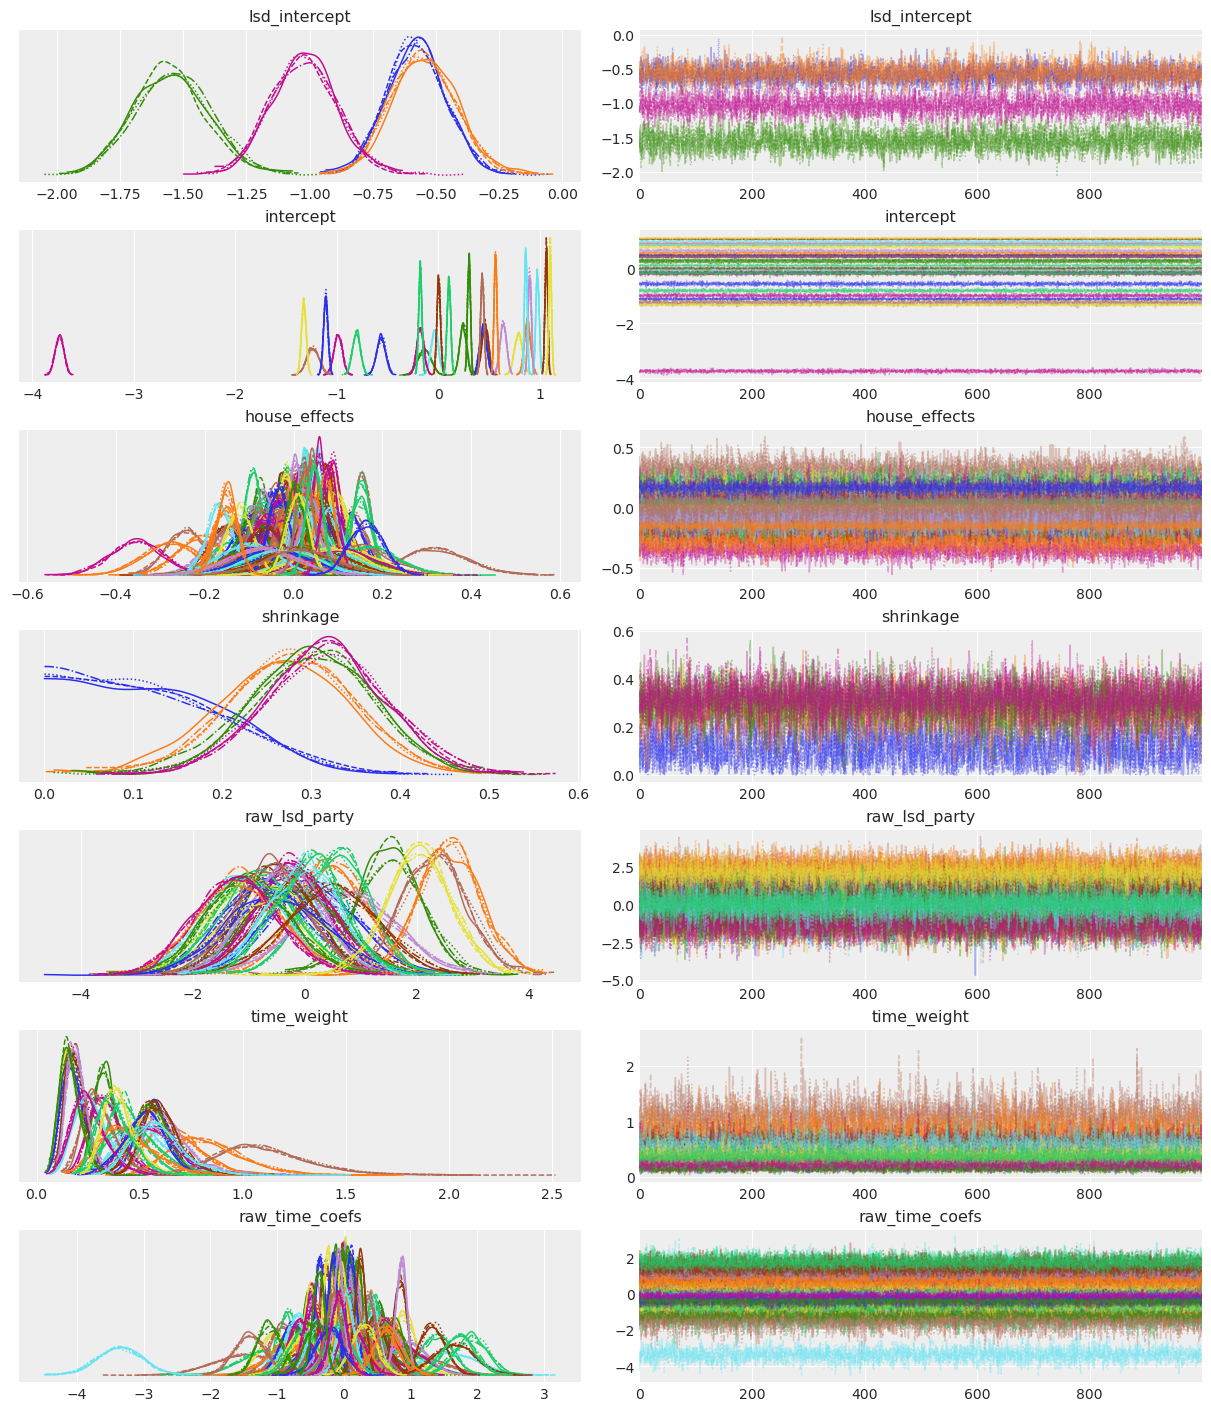

In [36]:
arviz.plot_trace(idata, var_names=["~time_effect", "~popularity"]);

### Unpooled model

In [43]:
election_id, COORDS["elections"] = polls["dateelection"].factorize()

In [47]:
with pm.Model(coords=COORDS) as unpooled_popularity:

    house_effect = pm.Normal("house_effect", 0, 0.15, dims="pollsters")

    week_election_effect = pm.GaussianRandomWalk(
        "week_election_effect", sigma=1.0, dims=("elections", "weeks", "parties")
    )

    popularity = pm.Deterministic(
        "popularity",
        aet.nnet.softmax(
            aet.concatenate(
                [
                    week_election_effect[election_id, week_id]
                    + house_effect[pollster_id, None],
                    aet.zeros((len(polls), 1)),
                ],
                axis=-1,
            )
        ),
        dims=("observations", "parties_complete"),
    )

    N_approve = pm.Multinomial(
        "N_approve",
        p=popularity,
        n=polls["samplesize"].values,
        observed=polls[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    idata = pm.sample(return_inferencedata=True)

(436, 7)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [week_election_effect, house_effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 104 seconds.


0, dim: observations, 436 =? 436
1, dim: parties_complete, 1 =? 7


There were 998 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4973885453731342, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 5.980501828963887e-06, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.39006742503772895, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8949559548395882, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller tha

In [48]:
COORDS["weeks_minus_origin"] = COORDS["weeks"][1:]

In [60]:
with pm.Model(coords=COORDS) as unpooled_popularity:
    baseline = pm.Normal("baseline")
    #    election_effect = pm.Normal("election_effect", sigma=0.15, dims="elections")
    #   house_effect = pm.Normal("house_effect", 0, 0.15, dims="pollsters")

    rw_init = aet.zeros(shape=(len(COORDS["elections"]), len(COORDS["parties"]), 1))
    rw_innovations = pm.Normal(
        "rw_innovations",
        dims=("elections", "parties", "weeks_minus_origin"),
    )
    raw_rw = aet.cumsum(aet.concatenate([rw_init, rw_innovations], axis=-1), axis=-1)
    week_election_effect = pm.Deterministic(
        "week_election_effect", raw_rw, dims=("elections", "parties", "weeks")
    )

    popularity = pm.Deterministic(
        "popularity",
        aet.nnet.softmax(
            aet.concatenate(
                [
                    baseline
                    #                    + election_effect[election_id, None]
                    + week_election_effect[election_id, :, week_id],
                    #                   + house_effect[pollster_id, None],
                    aet.zeros((len(polls), 1)),
                ],
                axis=-1,
            )
        ),
        dims=("observations", "parties_complete"),
    )

    N_approve = pm.Multinomial(
        "N_approve",
        p=popularity,
        n=polls["samplesize"].values,
        observed=polls[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rw_innovations, baseline]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 841 seconds.


0, dim: observations, 436 =? 436
1, dim: parties_complete, 1 =? 7


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in tr

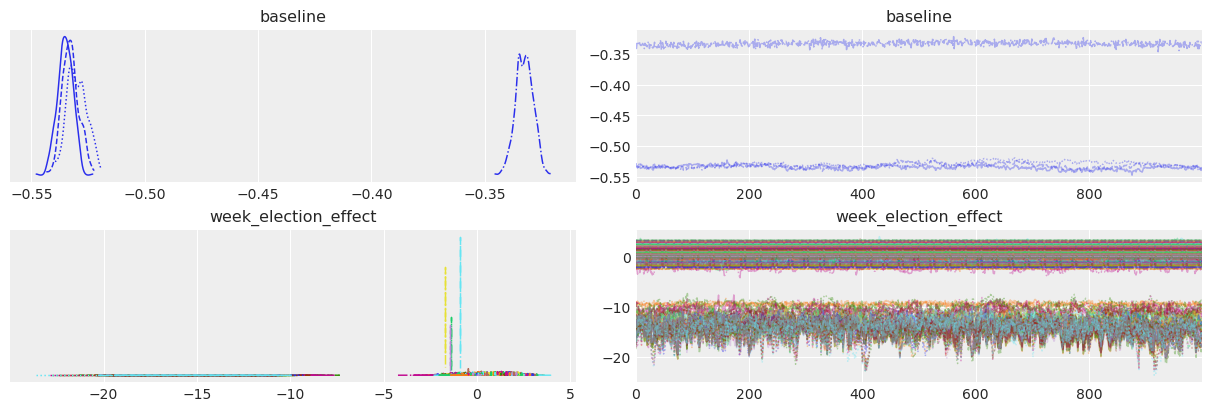

In [61]:
arviz.plot_trace(idata, var_names=["~popularity", "~rw_innovations"]);

### Hierarchical model

In [43]:
election_id, COORDS["elections"] = polls["dateelection"].factorize()

In [46]:
with pm.Model(coords=COORDS) as hierarchical_popularity:

    house_effect = pm.Normal("house_effect", 0, 0.15, dims="pollsters")

    week_effect = pm.Normal("week_effect", 0, 0.15, dims=("weeks", "parties"))
    sd = pm.HalfNormal("shrinkage", 0.2)
    raw_rw = pm.GaussianRandomWalk(
        "raw_rw", sigma=1.0, dims=("elections", "weeks", "parties")
    )
    week_election_effect = pm.Deterministic(
        "week_election_effect",
        week_effect + raw_rw * sd,
        dims=("elections", "weeks", "parties"),
    )

    print(
        (
            week_election_effect[election_id, week_id] + house_effect[pollster_id, None]
        ).tag.test_value.shape
    )
    popularity = pm.Deterministic(
        "popularity",
        aet.nnet.softmax(
            aet.concatenate(
                [
                    week_election_effect[election_id, week_id]
                    + house_effect[pollster_id, None],
                    aet.zeros((len(polls), 1)),
                ],
                axis=-1,
            )
        ),
        dims=("observations", "parties_complete"),
    )

    N_approve = pm.Multinomial(
        "N_approve",
        p=popularity,
        n=polls["samplesize"].values,
        observed=polls[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    idata = pm.sample(return_inferencedata=True)

(436, 6)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [raw_rw, shrinkage, week_effect, house_effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 966 seconds.


0, dim: observations, 436 =? 436
1, dim: parties_complete, 1 =? 7


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8905931202827749, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
